# Fraud detection using labelled data
Now that you're familiar with the main challenges of fraud detection, you're about to learn how to flag fraudulent transactions with supervised learning. You will use classifiers, adjust them and compare them to find the most efficient fraud detection model.

## Natural hit rate
In this exercise, you'll again use credit card transaction data. The features and labels are similar to the data in the previous chapter, and the data is heavily imbalanced. We've given you features X and labels y to work with already, which are both numpy arrays.

First you need to explore how prevalent fraud is in the dataset, to understand what the "natural accuracy" is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" you need to "beat" in order to get a better prediction than by doing nothing. In the following exercises, you'll create our first random forest classifier for fraud detection. That will serve as the "baseline" model that you're going to try to improve in the upcoming exercises.

In [1]:
# Import pandas and read csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(np.float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(np.float)
    return X,y

# Load Data
df = pd.read_csv("data/creditcard_data.csv").drop('Unnamed: 0',axis=1)
X, y = prep_data(df)

# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

99.00990099009901


This tells us that by doing nothing, we would be correct in 95.9% of the cases. So now you understand, that if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct. Let's see how a random forest does in predicting fraud in our data.

## Random Forest Classifier - part 1
Let's now create a first random forest classifier for fraud detection. Hopefully you can do better than the baseline accuracy you've just calculated, which was roughly 96%. This model will serve as the "baseline" model that you're going to try to improve in the upcoming exercises. Let's start first with splitting the data into a test and training set, and defining the Random Forest model. The data available are features X and labels y.

In [2]:
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

## Random Forest Classifier - part 2
Let's see how our Random Forest model performs without doing anything special to it. The model from the previous exercise is available, and you've already split your data in X_train, y_train, X_test, y_test.

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_curve

# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

0.9986798679867986


## Performance metrics for the RF model
In the previous exercises you obtained an accuracy score for your random forest model. This time, we know accuracy can be misleading in the case of fraud detection. With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. Moreover, the classification report tells you about the precision and recall of your model, whilst the confusion matrix actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

In [4]:
# Import the packages to get the different performance metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtain the predictions from our random forest model
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9993687707641195
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   1    9]]


You have now obtained more meaningful performance metrics that tell us how well the model performs, given the highly imbalanced data that you're working with. The model predicts 76 cases of fraud, out of which 73 are actual fraud. You have only 3 false positives. This is really good, and as a result you have a very high precision score. You do however, don't catch 18 cases of actual fraud. Recall is therefore not as good as precision. Let's try to improve that in the following exercises.

## Plotting the Precision Recall Curve
You can also plot a Precision-Recall curve, to investigate the trade-off between the two in your model. In this curve Precision and Recall are inversely related; as Precision increases, Recall falls and vice-versa. A balance between these two needs to be achieved in your model, otherwise you might end up with many false positives, or not enough actual fraud cases caught. To achieve this and to compare performance, the precision-recall curves come in handy.

Your Random Forest Classifier is available as model, and the predictions as predicted. You can simply obtain the average precision score and the PR curve from the sklearn package. The function plot_pr_curve() plots the results for you. Let's give it a try.

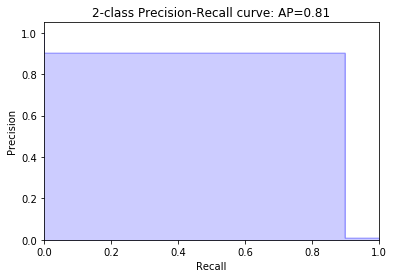

In [5]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(recall, precision, average_precision):
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  plt.show()

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

The ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

## Model adjustments
A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the class_weights option when defining your sklearn model. However, as you will see, it is a bit of a blunt force mechanism and might not work for your very special case.

In this exercise you'll explore the weight = "balanced_subsample" mode the Random Forest model from the earlier exercise. You already have split your data in a training and test set, i.e X_train, X_test, y_train, y_test are available. The metrics function have already been imported.



In [6]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9994019933554817
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   2    8]]


You can see that the model results don't improve drastically. We now have 3 less false positives, but now 19 in stead of 18 false negatives, i.e. cases of fraud we are not catching. If we mostly care about catching fraud, and not so much about the false positives, this does actually not improve our model at all, albeit a simple option to try. In the next exercises you'll see how to more smartly tweak your model to focus on reducing false negatives and catch more fraud.

## Adjusting your Random Forest to fraud detection
In this exercise you're going to dive into the options for the random forest classifier, as we'll assign weights and tweak the shape of the decision trees in the forest. You'll define weights manually, to be able to off-set that imbalance slightly. In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on.

The data in this exercise has already been split into training and test set, so you just need to focus on defining your model. You can then use the function get_model_results() as a short cut. This function fits the model to your training data, predicts and obtains performance metrics similar to the steps you did in the previous exercises.

In [7]:
def get_model_results(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  probs = model.predict_proba(X_test)
  print (classification_report(y_test, predicted))
  print (confusion_matrix(y_test, predicted))

In [8]:
# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',

			# Change depth of model
            max_depth=10,

			# Change the number of samples in leaf nodes
            min_samples_leaf=10,

			# Change the number of trees to use
            n_estimators=20, n_jobs=-1, random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.83      1.00      0.91        10

    accuracy                           1.00      1515
   macro avg       0.92      1.00      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1503    2]
 [   0   10]]


You can see by smartly defining more options in the model, you can obtain better predictions. You have effectively reduced the number of false negatives, i.e. you are catching more cases of fraud, whilst keeping the number of false positives low. In this exercise you've manually changed the options of the model. There is a smarter way of doing it, by using GridSearchCV, which you'll see in the next exercise!

## GridSearchCV to find optimal parameters
In this exercise you're going to tweak our model in a less "random" way, but use GridSearchCV to do the work for you.

With GridSearchCV you can define which performance metric to score the options on. Since for fraud detection we are mostly interested in catching as many fraud cases as possible, you can optimize your model settings to get the best possible Recall score. If you also cared about reducing the number of false positives, you could optimize on F1-score, this gives you that nice Precision-Recall trade-off.

In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 'max_features': ['auto', 'log2'],  'max_depth': [4, 8], 'criterion': ['gini', 'entropy']
}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'log2',
 'n_estimators': 30}

## Model results using GridSearchCV
You discovered that the best parameters for your model are that the split criterion should be set to 'gini', the number of estimators (trees) should be 30, the maximum depth of the model should be 8 and the maximum features should be set to "log2".

In [10]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini',
            max_depth=8, max_features='log2', min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   1    9]]


You've managed to improve your model even further. The number of false positives has now been slightly reduced even further, which means we are catching more cases of fraud. However, you see that the number of false positives actually went up. That is that Precision-Recall trade-off in action. To decide which final model is best, you need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with. Ultimately, this final decision should be made by you and the fraud team together.

## Logistic Regression
In this last lesson you'll combine three algorithms into one model with the VotingClassifier. This allows us to benefit from the different aspects from all models, and hopefully improve overall performance and detect more fraud. The first model, the Logistic Regression, has a slightly higher recall score than our optimal Random Forest model, but gives a lot more false positives. You'll also add a Decision Tree with balanced weights to it. The data is already split into a training and test set, i.e. X_train, y_train, X_test, y_test are available.

In order to understand how the Voting Classifier can potentially improve your original model, you should check the standalone results of the Logistic Regression model first.

In [11]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.57      0.80      0.67        10

    accuracy                           0.99      1515
   macro avg       0.79      0.90      0.83      1515
weighted avg       1.00      0.99      1.00      1515

[[1499    6]
 [   2    8]]


/Users/alejandro.robles/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


As you can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model. Let's give that a try

## Voting Classifier
Let's now combine three machine learning models into one, to improve our Random Forest fraud detection model from before. You'll combine our usual Random Forest model, with the Logistic Regression from the previous exercise, with a simple Decision Tree. You can use the short cut get_model_results() to see the immediate result of the ensemble model.

In [12]:
def get_model_results(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  #probs = model.predict_proba(X_test)
  print (classification_report(y_test, predicted))
  print (confusion_matrix(y_test, predicted))


# Import the packages
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, n_jobs=1)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard', n_jobs=1)

# Get the results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   2    8]]


/Users/alejandro.robles/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


You see that by combining the classifiers, you can take the best of multiple models. You've increased the cases of fraud you are catching from 76 to 78, and you only have 5 extra false positives in return. If you do care about catching as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together you indeed managed to improve performance.

## Adjust weights within the Voting Classifier
You've just seen that the Voting Classifier allows you to improve your fraud detection performance, by combining good aspects from multiple models. Now let's try to adjust the weights we give to these models. By increasing or decreasing weights you can play with how much emphasis you give to a particular model relative to the rest. This comes in handy when a certain model has overall better performance than the rest, but you still want to combine aspects of the others to further improve your results.

In [13]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.91      1.00      0.95        10

    accuracy                           1.00      1515
   macro avg       0.95      1.00      0.98      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   0   10]]


/Users/alejandro.robles/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The weight option allows you to play with the individual models to get the best final mix for your fraud detection model. Now that you have finalized fraud detection with supervised learning, let's have a look at how fraud detetion can be done when you don't have any labels to train on.
